### import libraries

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from model import DNN
from inverse_config import *


### experimental pressure values on the bottom

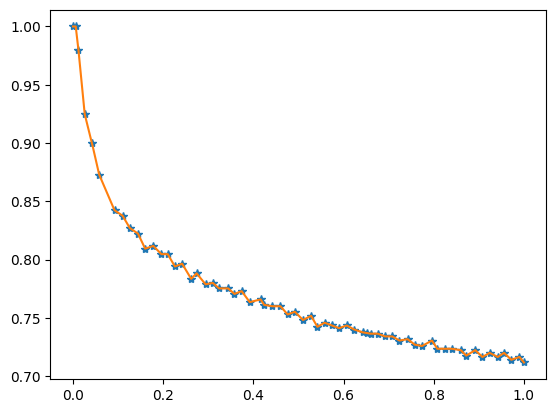

In [2]:
# bottom pressure in nondimensional form
p_drop = np.genfromtxt('data/p_drop.csv', delimiter=',') * 1e+6 / Pk

# data time in nondimensional form
t_drop = np.genfromtxt('data/t_drop.csv', delimiter=',') * 86400 / t_end

f_drop = scipy.interpolate.interp1d(t_drop, p_drop)

t1 = np.linspace(t0, 1., 501)
plt.plot(t_drop, f_drop(t_drop), '*')
plt.plot(t1, f_drop(t1))
plt.show()

### train model

[0.0009000000000000001]
epoch 4000: loss 9.805168
C_skv: 1.6979188919067383e-06
G: 10179.316997528076
mu_h: 0.02462141662836075
k: 1.587459683418274e-14


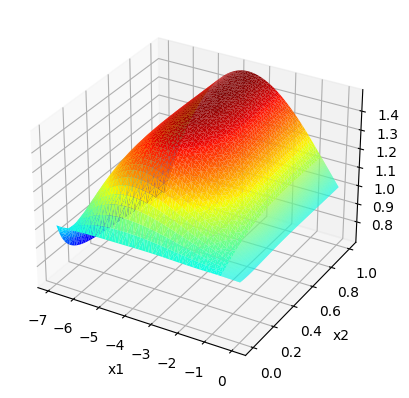

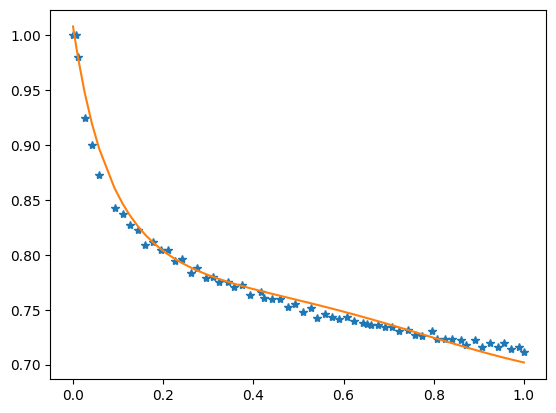

[0.0008100000000000001]
epoch 8000: loss 3.819723
C_skv: 2.443770170211792e-06
G: 10947.41940498352
mu_h: 0.02890841066837311
k: 2.281787395477295e-14


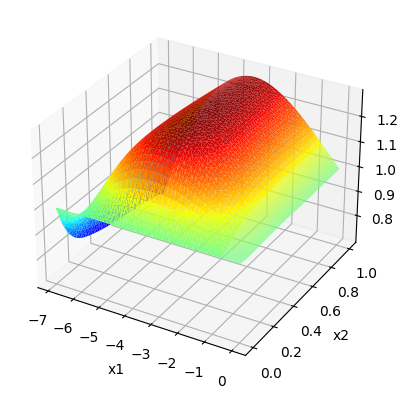

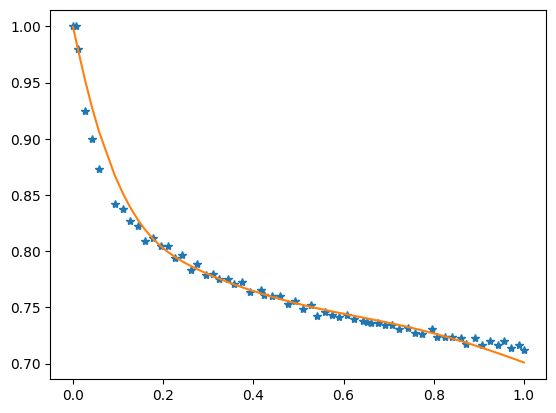

[0.000729]
[0.0006561000000000001]
epoch 12000: loss 2.098609
C_skv: 3.0013892650604245e-06
G: 5778.650641441345
mu_h: 0.036922529339790344
k: 3.3016202449798583e-14


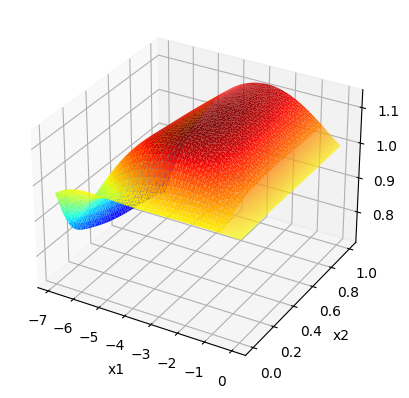

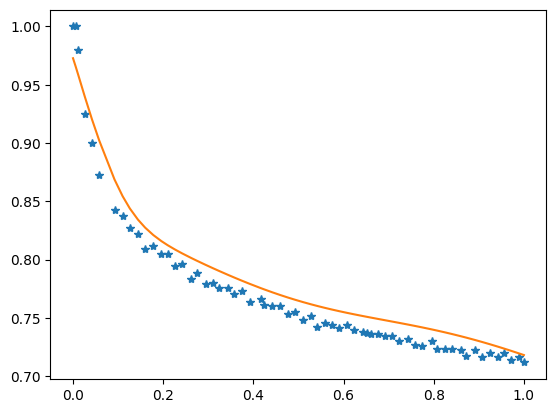

[0.00059049]
epoch 16000: loss 0.791073
C_skv: 2.732833862304687e-06
G: 8161.475658416748
mu_h: 0.043222939968109136
k: 4.569002628326416e-14


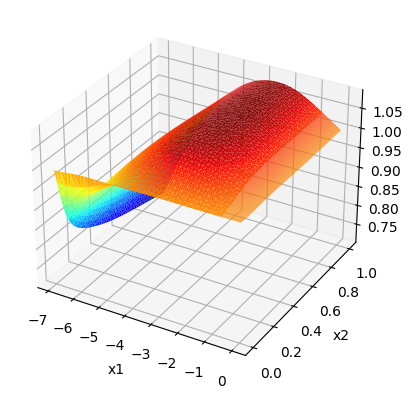

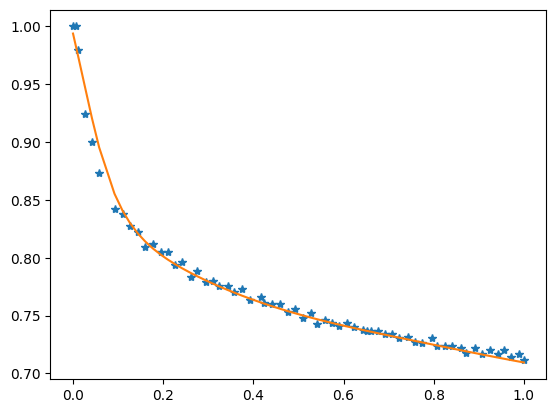

[0.000531441]
epoch 20000: loss 0.419222
C_skv: 2.178962230682373e-06
G: 6456.121802330017
mu_h: 0.05478280186653137
k: 5.902411937713623e-14


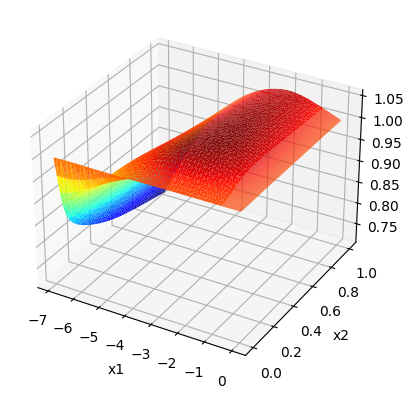

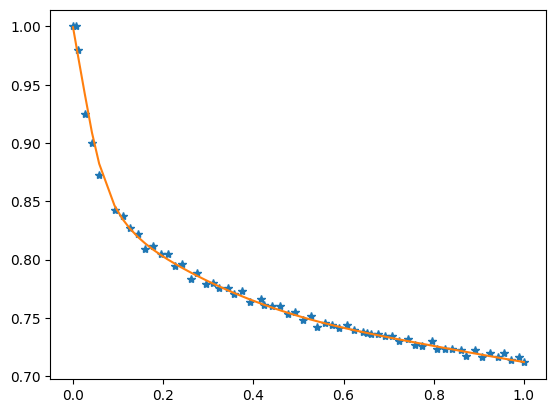

[0.0004782969]
[0.00043046721]
epoch 24000: loss 0.262971
C_skv: 1.9909297227859495e-06
G: 8509.653806686401
mu_h: 0.05667156577110291
k: 7.222564220428467e-14


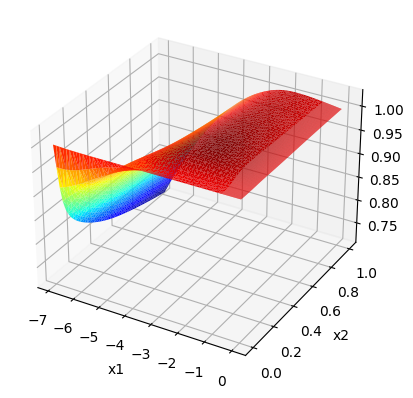

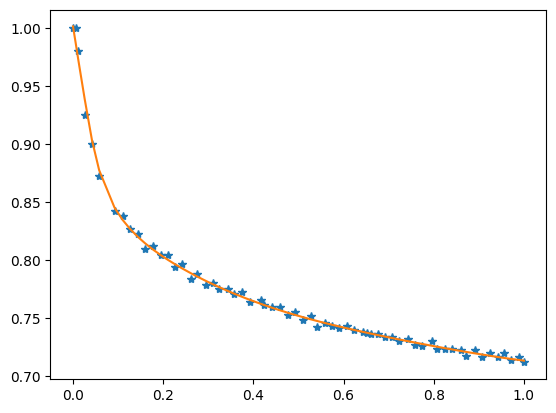

[0.000387420489]
epoch 28000: loss 0.172295
C_skv: 1.9745683670043942e-06
G: 5845.327973365784
mu_h: 0.04833464920520783
k: 8.510403633117676e-14


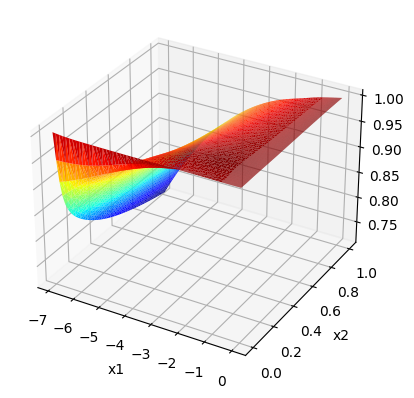

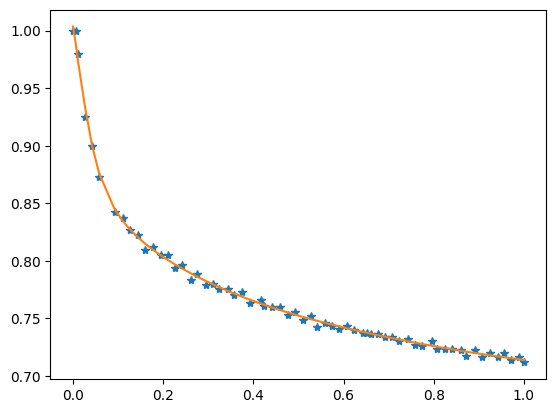

[0.0003486784401]
epoch 32000: loss 0.126549
C_skv: 2.0886459350585936e-06
G: -534.9213257431984
mu_h: 0.03294343948364258
k: 9.686988830566406e-14


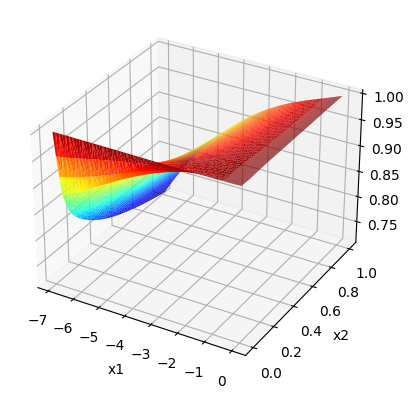

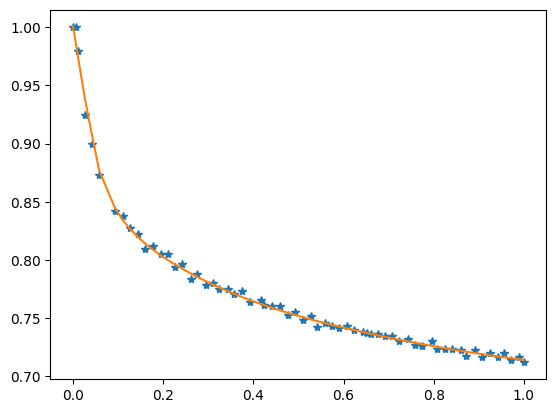

[0.00031381059609000004]


In [3]:
# Initialization
device = torch.device('cuda')
lr = 0.001
epochs = 24000

tol = 0.
n_t = 50

u = torch.linspace(Rk/2/r0, Rk/r0, 70)
u = torch.log(u)
u1 = torch.linspace(np.log(rc/r0), np.log(Rk/2/r0), 50)
u = torch.hstack((u, u1[:-1]))
u = torch.sort(u)[0]

t = torch.linspace(t0, 1, n_t)

t_data = torch.from_numpy(t_drop).float()

grid = torch.cartesian_prod(t, u).float().to(device)
grid = grid[grid[:, 0].argsort()]

# p(u,0)=1
bnd1 = torch.cartesian_prod(torch.tensor([0.]), u).float().to(device)
bndval1 = torch.tensor([1.]).to(device)

#bnd2(u(-1), t)=1
bnd2 = torch.cartesian_prod(t, torch.tensor([u[-1].item()])).float().to(device)
bndval2 = torch.tensor([1.]).to(device)

#bnd3
bnd3 = torch.cartesian_prod(t, torch.tensor([u[0].item()])).float().to(device)

bnd_data = torch.cartesian_prod(t_data, torch.tensor([u[0].item()])).float().to(device)

bnd_value = torch.from_numpy(p_drop).float().to(device)


NN = nn.Sequential(
    nn.Linear(2, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 1)).to(device)


# Initialize neural network
model = DNN(NN, G, k, C_skv, mu_h, tol, n_t).to(device)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

model_p_drop = []

# Train PINNs
for epoch in range(1, epochs+1):
    model.train()

    def closure():
        optimizer.zero_grad()
        L_t, W = model.loss_weights(grid)
        loss_bnd1 = model.loss_dirichlet(bnd1, bndval1).reshape(-1)
        loss_bnd2 = model.loss_dirichlet(bnd2, bndval2).reshape(-1)
        loss_bnd3 = model.loss_operator(bnd3).reshape(-1)
        loss_data = model.loss_dirichlet(bnd_data, bnd_value).reshape(-1)
        loss = torch.mean(W*L_t) + 10000*(torch.hstack([loss_bnd1, loss_bnd2, loss_bnd3, loss_data])).mean() #, loss_data
        loss.backward()
        return loss


    # Optimize loss function
    loss_pde = optimizer.step(closure)
    if epoch % 3000 == 0:
        scheduler.step()
        print(scheduler.get_last_lr())
    loss_value = loss_pde.item() if not isinstance(loss_pde, float) else loss_pde


    if epoch%4000==0:
        print(f'epoch {epoch}: loss {loss_value:.6f}')
        print('C_skv:', model.C_skv.item()*1e-6)
        print('G:', model.G.item()*1e+4)
        print('mu_h:', model.mu_h.item()*25e-3)
        print('k:', model.k.item()*1e-14)

        L_t, W = model.loss_weights(grid)
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(projection='3d')
        ax1.plot_trisurf(grid[:, 1].cpu().detach().numpy().reshape(-1), grid[:, 0].cpu().detach().numpy().reshape(-1),
                    model(grid).cpu().detach().numpy().reshape(-1), cmap=cm.jet, linewidth=0.2, alpha=1)
        ax1.set_xlabel("x1")
        ax1.set_ylabel("x2")
        plt.show()

        plt.plot(t_data.cpu().detach().numpy().reshape(-1), f_drop(t_data).reshape(-1), '*')
        plt.plot(t_data.cpu().detach().numpy().reshape(-1), model(bnd_data).cpu().detach().numpy().reshape(-1))
        plt.show()

    if epoch == 5 or epoch%3000 == 0:
        model_p_drop.append(model(bnd_data).cpu().detach().numpy().reshape(-1))


### graphs for inverse task

<Figure size 640x480 with 0 Axes>

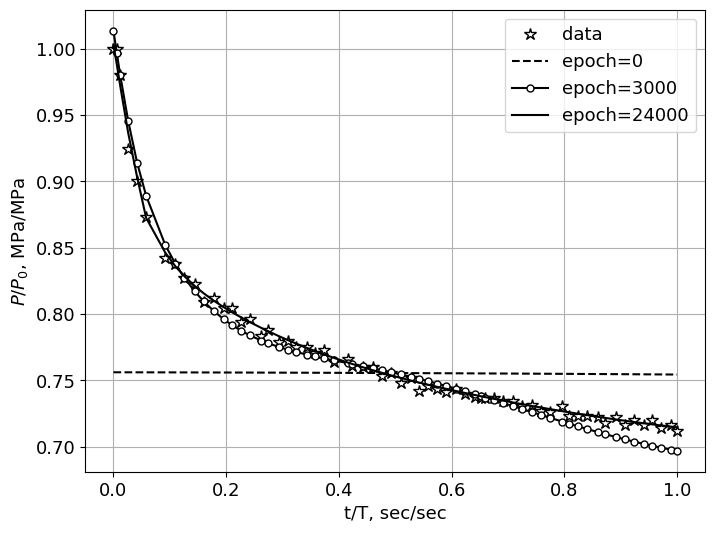

In [5]:
t_data = torch.from_numpy(t_drop).float()
u = torch.linspace(Rk/2/r0, Rk/r0, 70)
u = torch.log(u)
u1 = torch.linspace(np.log(rc/r0), np.log(Rk/2/r0), 50)
u = torch.hstack((u, u1[:-1]))
u = torch.sort(u)[0]
bnd_data = torch.cartesian_prod(t_data, torch.tensor([u[0].item()])).float().to(device)

import matplotlib
plt.figure()
plt.figure(figsize=(8, 6))
font = {'serif' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

plt.plot(t_data.cpu().detach().numpy().reshape(-1), f_drop(t_data).reshape(-1), '*', c='k', mfc='w', mec='k',ms=9, label = 'data')

plt.plot(t_data.cpu().detach().numpy().reshape(-1), model_p_drop[0], '--', c='k', mfc='w', mec='k',ms=4, label = 'epoch=0')
plt.plot(t_data.cpu().detach().numpy().reshape(-1), model_p_drop[1], 'o-', c='k', mfc='w', mec='k',ms=5, label = 'epoch=3000')
plt.plot(t_data.cpu().detach().numpy().reshape(-1), model_p_drop[-1], '-', c='k', mfc='w', mec='k',ms=6, label = 'epoch=24000')
plt.xlabel('t/T, sec/sec')
plt.ylabel('$P/P_0$, MPa/MPa')
plt.legend(loc='upper right')
plt.grid(True)
# plt.savefig('PINN_p_drop.eps',dpi = 1000)
plt.show()


### graphs of viscosity and flow rate

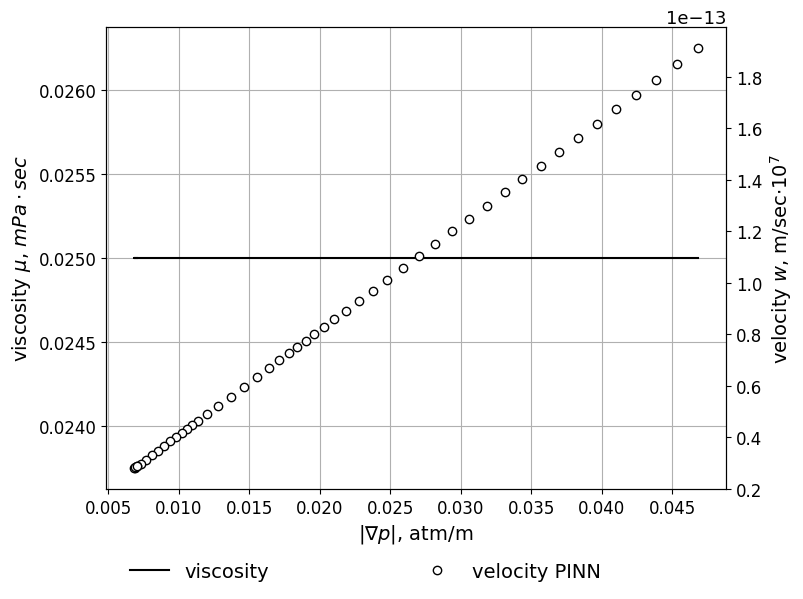

In [4]:
import matplotlib
from inverse_utils import mu_oil

C_skv = model.C_skv.item()*1e-6
G = model.G.item()*1e+4
mu_h = model.mu_h.item()*25e-3
k = model.k.item()*1e-14

u = torch.linspace(np.log(rc/r0), np.log(Rk/r0), 50)
t = torch.linspace(0., 1., 50)

grid_grad = torch.cartesian_prod(torch.tensor([t[4].item()]), u).float().to(device)

grid_grad.requires_grad_()

pressure = model(grid_grad)[:, 0:1].sum(0)

dp_g, = torch.autograd.grad(pressure, grid_grad)
p_x, _ = dp_g[:, 1:], dp_g[:, 0:1]

w = k/mu_oil(p_x, grid_grad[:, 1:], G, mu_h)*p_x

font = {'serif' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(p_x.detach().cpu().numpy(), mu_oil(p_x, grid_grad[:, 1:], G, mu_h).detach().cpu().numpy(), c='k', mfc='w', mec='k',ms=6, label='viscosity')
ax2 = ax.twinx()
ax2.plot(p_x.detach().cpu().numpy(), w.detach().cpu().numpy(), 'o', c='k', mfc='w', mec='k',ms=6, label = 'velocity PINN')
ax.grid()
ax.set_xlabel(r'$|\nabla p|$, atm/m', fontsize=14)
ax.set_ylabel('viscosity $\mu$, $mPa\cdot sec$', fontsize=14)
ax2.set_ylabel('velocity $w$, m/sec$\cdot 10^7$', fontsize=14)
ax.legend(loc='upper center', fontsize=14, frameon=False, bbox_to_anchor=(0.15, -0.12), ncol=1)
ax2.legend(loc='upper center', fontsize=14, frameon=False, bbox_to_anchor=(0.65, -0.12), ncol=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
# plt.savefig('mu_w_grad.eps', format='eps', bbox_inches="tight", dpi=1000)
plt.show()